# Анализ убытков развлекательного приложения 🧩

## Содержание
1) [Описание проекта](#project_summary)  
2) [Загрузка и подготовка данных к анализу](#data_download)  
3) [Функции для расчета и анализа LTV, ROI, удержания и конверсии](#functions)  
4) [Исследовательский анализ данных](#eda)  
5) [Маркетинг](#marketing)  
6) [Оценка окупаемости рекламы для привлечения пользователей](#pr_success)  
7) [Общие выводы](#conclusion)

<a id='project_summary'></a>
## Описание проекта

**Задача:**

Развлекательное приложение Procrastinate Pro+ несколько прошлых месяцев постоянно несло убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Перед нами стоит задача выяснить причины этой ситуации.

На основании данных о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, их покупках за этот период, а также рекламных расходах. Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

**Цель исследования:**

Разобраться в причинах последних убытков бизнеса и сформулировать советы для отдела маркетинга для улучшения картины.

**Ход исследования:**

Загрузим данные о визитах, заказах и расходах. Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.
Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Изучим:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Оценим окупаемость рекламы для привлечения пользователей с помощью LTV и ROI. Проанализируем общую окупаемость рекламы, и в том числе  с разбивкой по устройствам, по странам, по рекламным каналам. Опишем возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела. При решении этого шага будем считать, что мы смотрим данные 1-го ноября 2019 года и что в нашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

<a id='data_download'></a>
## Загрузка и подготовка данных к анализу

Для начала произведём импорт всех необходимых нам библиотек:

In [1]:
# импорт библиотеки pandas
import pandas as pd

#импорт библиотеки numpy для операций с массивами
import numpy as np

# импорт библиотеки визуализации seaborn
import seaborn as sns

# импорт библиотеки matplotlib для продвинутой работы с графиками
import matplotlib.pyplot as plt

# импорт библиотеки для проведения статистических тестов
from scipy import stats as st

# импорт библиотеки для работы с датами
from datetime import datetime, timedelta

Прочитаем данные из файла с информацией о посещениях сайта. Выведем на экран первые 5 строк датасета:

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('visits_info_short.csv')
display(visits.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Согласно документации к данным таблица visits_info_short (лог сервера с информацией о посещениях сайта) содержит следующую информацию:

- User Id — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Session start — дата и время начала сессии
- Session End — дата и время окончания сессии
- Channel — идентификатор рекламного источника, из которого пришел пользователь
- Region - страна пользователя
    
Сразу можно заметить в названиях столбцов нарушение хорошего стиля. Исправим это, приведя их к нижнему регистру:

In [3]:
visits.columns = visits.columns.str.lower()
visits.columns

Index(['user id', 'region', 'device', 'channel', 'session start',
       'session end'],
      dtype='object')

Ещё одним нарушением хорошего стиля является присутствие в названиях колонок пробелов. Исправим и это тоже:

In [4]:
visits = visits.rename(columns = {'user id':'user_id', 'session start':'session_start', 'session end':'session_end'})
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Посмотрим главные характеристики таблицы, воспользовавшись методом *info()*:

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Можно заметить, что таблица не содержит пропусков. Проверим, есть ли в ней явные дубликаты:

In [6]:
visits.duplicated().sum()

0

Дубликатов тоже не оказалось. Для удобной работы с датами приведём данные граф 'session_start' и 'session_end' к типу datetime:

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

Графы 'region', 'device' и 'channel' проверим на предмет наличия скрытых дубликатов и некорректных значений. Посмотрим на уникальные значения в этих столбцах:

In [8]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [9]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [10]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Никаких подозрительных значений не обнаружилось.  
Перейдём к изучению информации в следующем файле, сохраним её в переменной:

In [11]:
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('orders_info_short.csv')
display(orders.head())

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Согласно документации к данным таблица orders_info_short (информация о заказах):

- User Id — уникальный id пользователя, который сделал заказ
- Event Dt — дата и время покупки
- Revenue — выручка

Исправим нарушение хорошего стиля в заголовках:

In [12]:
orders.columns = ['user_id', 'event_dt', 'revenue']
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

Посмотрим главные характеристики таблицы, воспользовавшись методом *info()*:

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Таблица не содержит пропусков. Проверим, имеются ли в ней дубликаты:

In [14]:
orders.duplicated().sum()

0

Дубликатов тоже не оказалось. Для удобной работы с датами приведём данные графы 'event_dt'  к типу datetime:

In [15]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

Изучим информацию в последнем файле, сохраним её в переменной:

In [16]:
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    costs = pd.read_csv('costs_info_short.csv')
display(costs.head())

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Согласно документации к данным таблица costs_short (информация о затратах на маркетинг):

- Channel — идентификатор рекламного источника
- Dt — дата
- Costs — затраты на этот рекламный источник в этот день

Устраним нарушение хорошего стиля в названиях граф:

In [17]:
costs.columns = costs.columns.str.lower()
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

Посмотрим главные характеристики таблицы, воспользовавшись методом *info()*:

In [18]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Убедимся в отсутствии дубликатов:

In [19]:
costs.duplicated().sum()

0

Посмотрим уникальные значения в столбце 'channel', чтобы убедиться, что там не содержатся неявные дубликаты или некорректные значения:

In [20]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Подозрительных значений не оказалось. Для удобной работы с датами приведём данные графы 'dt'  к типу datetime:

In [21]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
costs.dtypes

dt          object
channel     object
costs      float64
dtype: object

Итак, на первом этапе исследования мы изучили исходные данные, убедились в отсутствии пропусков и дубликатов. Проверили данные на наличие неявных дубликатов,  которых в нашем массиве не оказалось. Устранили нарушение хорошего стиля в названиях граф, а также привели тип данных к более подходящему для работы (в частности, информацию о датах).  
Закончив с предобработкой данных, можно переходить к следующим шагам исследования.

<a id='functions'></a>
## Функции для расчета и анализа LTV, ROI, удержания и конверсии

Для ответа на поставленные вопросы необходимо написать функции для построения пользовательских профилей, а также расчета дополнительных характеристик. Соберём все нужные нам функции  в текущем шаге исследования:

    - для создания профилей (get_profiles()),
    - расчёта удержания (get_retention()),
    - конверсии (get_conversion()),
    - LTV и ROI(get_ltv()).

In [22]:
# функция для получения пользовательских профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [23]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [24]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [25]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi():

In [26]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [27]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [28]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [29]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Теперь можно переходить к исследовательскому анализу данных.

<a id='eda'></a>
## Исследовательский анализ данных

Получим профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу развлекательного приложения Procrastinate Pro+:

In [30]:
events = None # событий нет

# получаем профили пользователей
profiles = get_profiles(visits, orders, events, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [31]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


В результате мы получили таблицу о 150008 пользователях. Определим минимальную и максимальную дату привлечения пользователей:

In [32]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [33]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

Таким образом, период анализа нашего исследования с 1 мая по 27 октября 2019 года. Посмотрим, из каких стран приходят пользователи, а также определим, какие страны дают больше всего платящих пользователей:

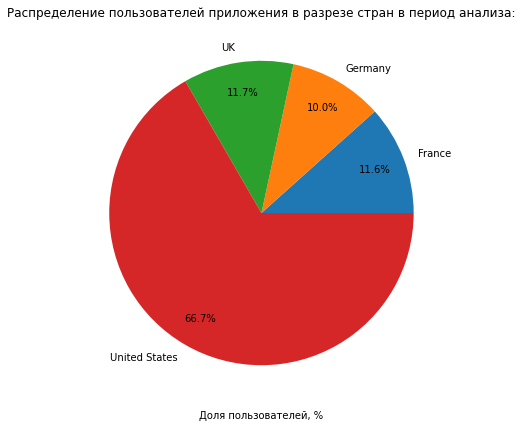

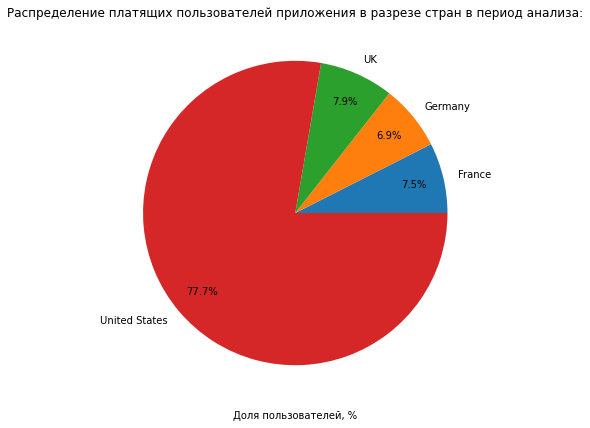

In [34]:
# напишем функцию, которая построит круговую диаграмму распределения пользователей приложения
def pie_plot(data, factor, name):
    data.groupby([factor])['user_id'].count().plot(kind='pie', figsize=(7, 7), autopct='%1.1f%%', pctdistance=0.8)
    plt.title(name)
    plt.xlabel('Доля пользователей, %')
    plt.ylabel(' ')
    plt.show();
pie_plot(profiles, 'region', 'Распределение пользователей приложения в разрезе стран в период анализа:')
print ('')
# информацию о платящих пользователях сохраним в отдельный датафрейм
pay_profiles = profiles.query('payer == True')
pie_plot(pay_profiles, 'region', 'Распределение платящих пользователей приложения в разрезе стран в период анализа:')

In [35]:
# напишем функцию, которая рассчитает долю платящих пользователей
def pay_percent(data, factor):
    table = (
    data.groupby(factor, as_index=False)
    .agg({'user_id': 'count', 'payer': 'sum'})
)
    table.columns = ['region', 'total', 'pay']
    table['pay_percent'] = 100*table['pay']/table['total']
    table= table.sort_values(by = 'pay_percent', ascending = False)
    return table.style.format({'pay_percent':'{:.2f}%'})
pay_percent(profiles, 'region')

,region,total,pay,pay_percent
3,United States,100002,6902,6.90%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%


Развлекательное приложение Procrastinate Pro+ наиболее популярно среди пользователей Соединённых Штатов Америки (их доля около 70% от общего числа пользователей). Пользователи из Англии, Германии и Франции занимают 10-12%.  
Платящие пользователи из США составляют около 78%, а процент пользователей из трёх остальных исследуемых стран находится на уровне 7-8%.  
Если посмотреть на доли платящих пользователей в общем числе пользователей региона, то лидирующую позицию также занимают США (6.9%, что почти на три процентных пункта выше, чем в Германии, Англии и Франции).

Посмотрим, какие устройства пользователи чаще всего используют для посещения приложения:

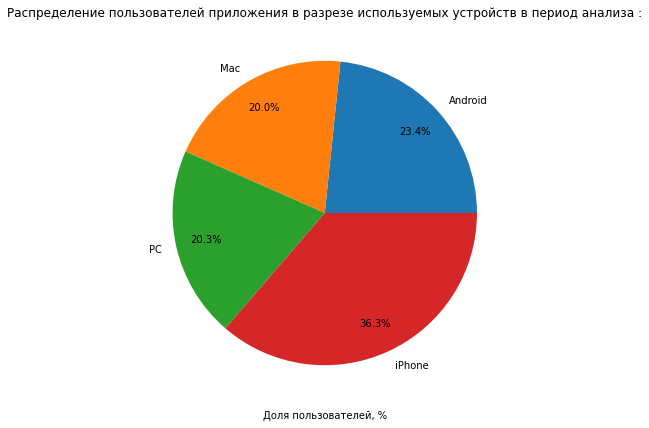

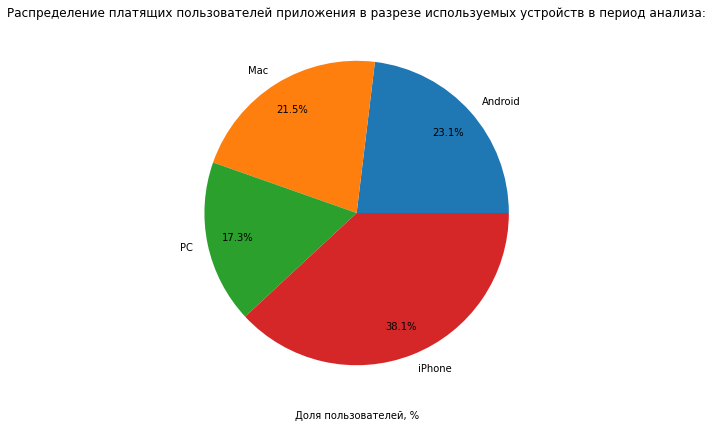

In [36]:
pie_plot(profiles, 'device', 'Распределение пользователей приложения в разрезе используемых устройств в период анализа :')
print ('')
pie_plot(pay_profiles, 'device', 'Распределение платящих пользователей приложения в разрезе используемых устройств в период анализа:')

In [37]:
pay_percent(profiles, 'device')

,region,total,pay,pay_percent
1,Mac,30042,1912,6.36%
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%


Большинство пользователей приложения используют устройства iPhone (36.3%). Около 20% пользователей посещают приложение с устройств PC и Mac, а 23.4% - с устройств Android.  
Платящие пользователи приложения Procrastinate Pro+ распределились в том же порядке: 38.1% - IPhone, 23.1% - Android, 21.5% - Mac и 17.3% - PC.  
Доля платящих пользователей по отношению к общему числу пользователей самая высокая среди владельцев Mac и iPhone (6.36% и 6.21% соответственно). Реже других платящие пользователи используют PC (5.05%).

Интересно посмотреть, по каким каналам шло привлечение пользователей развлекательного приложения Procrastinate Pro+, и в том числе платящих пользователей:

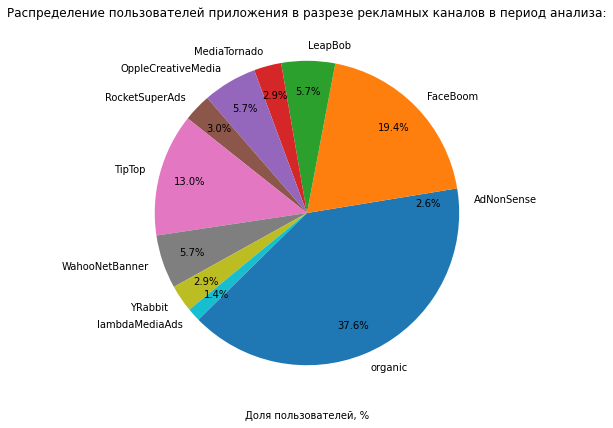

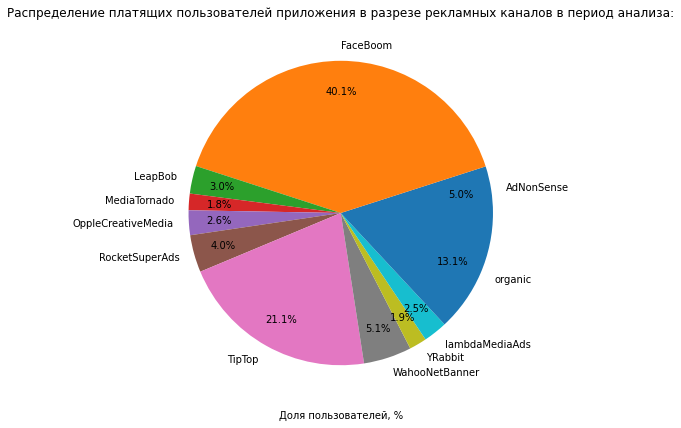

In [38]:
pie_plot(profiles, 'channel', 'Распределение пользователей приложения в разрезе рекламных каналов в период анализа:')
print ('')
pie_plot(pay_profiles, 'channel', 'Распределение платящих пользователей приложения в разрезе рекламных каналов в период анализа:')

In [39]:
pay_percent(profiles, 'channel')

,region,total,pay,pay_percent
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


В общем числе пользователей наибольший удельный вес занимают органические пользователи (37.6%), т. е. такие пользователи, которые приходят на ресурс после поиска через Google, Яндекс, Bing и т. п., не используя рекламные ссылки. Однако процент платящих пользователей среди них значительно ниже - только 13.1%. Интерес большого количества пользователей приложения был вызван рекламными каналами FaceBoom (19.4%) и TipTop (13.0%). Платящих пользователей среди них тоже много - 40.1% и 21.1% соответственно от общего количества платящих пользователей.  
Самый небольшой удельный вес платящих пользователей можно заметить среди органических пользователей (2.06% от всех органических пользователей). В то же время пользователи, привлеченные каналами FaceBoom и AdNonSense, чаще других используют платную версию приложения (12.2% и 11.34% соответственно).

Таким образом, на текущем шаге мы построили профили пользователей развлекательного приложения Procrastinate Pro+  и получили средний портрет платящего пользователя: он из США, посещает приложение с устройста iPhone и был привлечён рекламным каналом FaceBoom. Что касается органических пользователей, на привлечение которых компания не потратила средств, то процент платящих среди них оставляет желать лучшего.

<a id='marketing'></a>
## Маркетинг

Далее изучим информацию о затратах на маркетинг (мы сохранили её в переменной costs). Сначала посчитаем общую сумму этих расходов:

In [40]:
round(costs['costs'].sum(), 2)

105497.3

Таким образом, общая сумма затрат на рекламу в исследуемый период составила около 105.5 тыс. у.е. Посмотрим также, как данная сумма распределилась между рекламными источниками, для чего сформируем сводную таблицу с группировкой по 'channel': 

In [41]:
costs.groupby(['channel'])['costs'].sum().sort_values(ascending = False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

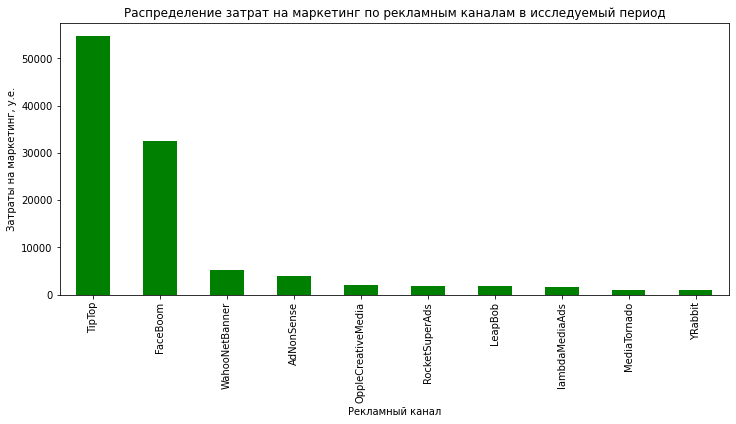

In [42]:
costs.groupby(['channel'])['costs'].sum().sort_values(ascending = False).plot(
    kind = 'bar', color = 'green', figsize=(12, 5))
plt.title('Распределение затрат на маркетинг по рекламным каналам в исследуемый период')
plt.xlabel('Рекламный канал')
plt.ylabel('Затраты на маркетинг, у.е.');

В результате мы выяснили, что наибольшее количество денежных средств было вложено в рекламу на TipTop (около 54.8 тыс. у.е.) и на FaceBoom (около 32.4 тыс. у.е.).

Изучим динамику затрат на рекламу в период с 1 мая по 27 октября 2019 года по всем пользователям и в разрезе рекланых каналов:

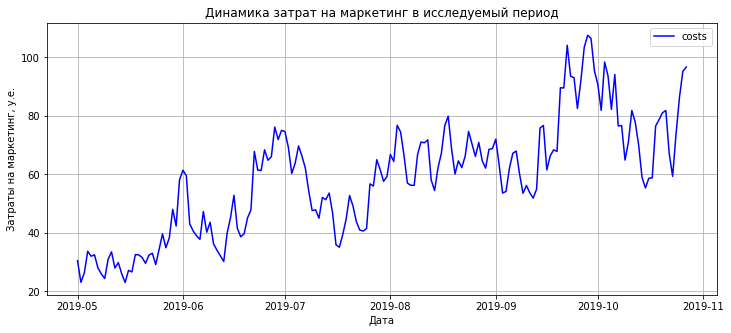

In [43]:
costs.pivot_table(index = 'dt', values = 'costs').plot(grid=True, figsize=(
    12,5), color='blue')
plt.title('Динамика затрат на маркетинг в исследуемый период')
plt.xlabel('Дата')
plt.ylabel('Затраты на маркетинг, у.е.');

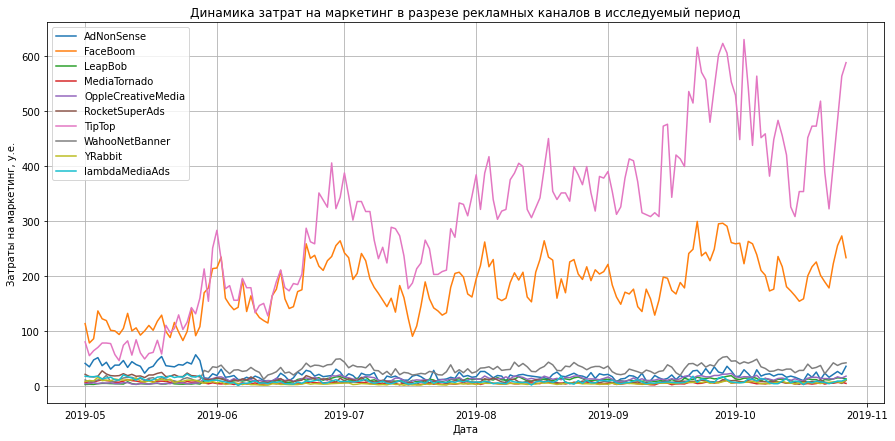

In [44]:
costs.groupby(['channel', 'dt'])['costs'].sum().unstack('channel').plot(grid=True, figsize=(15,7))
plt.legend()
plt.title('Динамика затрат на маркетинг в разрезе рекламных каналов в исследуемый период')
plt.xlabel('Дата')
plt.ylabel('Затраты на маркетинг, у.е.');

График рекламных затрат демострирует нам тенденцию к росту в период с мая по октябрь 2019 года, пик этих затрат пришёлся на конец сентября. Можно заметить, что наращивание рекламных затрат происходило по двум рекламным каналам: TipTop и FaceBoom. По остальным каналам затраты на маркетинг были стабильны и значительно ниже.

Нам предстоит выяснить, сколько в среднем стоило привлечение одного покупателя для всего проекта и для каждого источника. Для этой цели прибегнем к уже рассчитанной нами таблице профилей пользователей.  
Сначала найдём среднюю стоимость привлечения одного покупателя для всего проекта (предварительно исключив органических пользователей, так как на их привлечение не было никаких затрат, и присутствие таких пользователей в массиве для расчета сильно исказит значение среднего):

In [45]:
round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2)

1.13

Таким образом, в исследуемый период привлечение одного пользователя стоило компании в среднем 1.13 у.е. Посмотрим, какова картина для каждого рекламного источника:

In [46]:
profiles.query('channel != "organic"').groupby(['channel'])['acquisition_cost'].mean(
).sort_values(ascending = False)

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
Name: acquisition_cost, dtype: float64

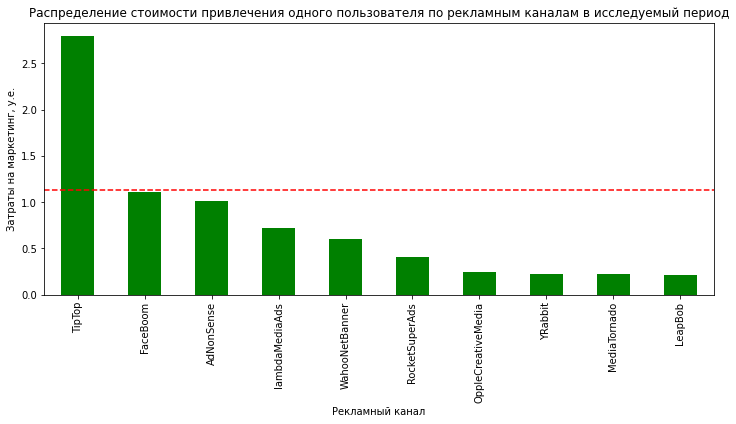

In [47]:
profiles.query('channel != "organic"').groupby(['channel'])['acquisition_cost'].mean().sort_values(
    ascending = False).plot(
    kind = 'bar', color = 'green', figsize=(12, 5))
# Добавим линию средней стоимости привлечения одного покупателя для всего проекта
plt.axhline(y=1.13, color='red', linestyle='--')
plt.title('Распределение стоимости привлечения одного пользователя по рекламным каналам в исследуемый период')
plt.xlabel('Рекламный канал')
plt.ylabel('Затраты на маркетинг, у.е.');

Можно заметить, что наибольшие среднепользовательские рекламные затраты наблюдались по каналу TipTop (2.8 у.е.), что больше чем в два раза превышает среднепользовательские рекламные затраты для всего проекта. Далее по затратности следуют каналы FaceBoom (1.1 у.е. за пользователя) и AdNonSense (1.0 у.е. за пользователя).  
Для того, чтобы определить целесообразность данных затрат, нужно оценить окупаемость рекламы для привлечения пользователей, чем мы займемся на следующем этапе исследования.

<a id='pr_success'></a>
##  Оценка окупаемости рекламы для привлечения пользователей

Установим момент и горизонт анализа данных. Предположим, что на календаре 1 ноября 2019 года. В нашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей. Таким образом, горизонт анализа данных возьмем равным 14 дням. На текущем шаге нас интересуют только те пользователи, которые заинтересоватись продуктом благодаря рекламе. Органические пользователи находят нас сами и, таким образом, наши рекламные вложения на них не влияют.

In [48]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

# Исключим органических пользователей, сохраним результат в отдельной переменной
not_organic_profiles = profiles.query('channel != "organic"')

### Анализ общей окупаемости рекламы

Теперь можно приступать к анализу.  
Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi():

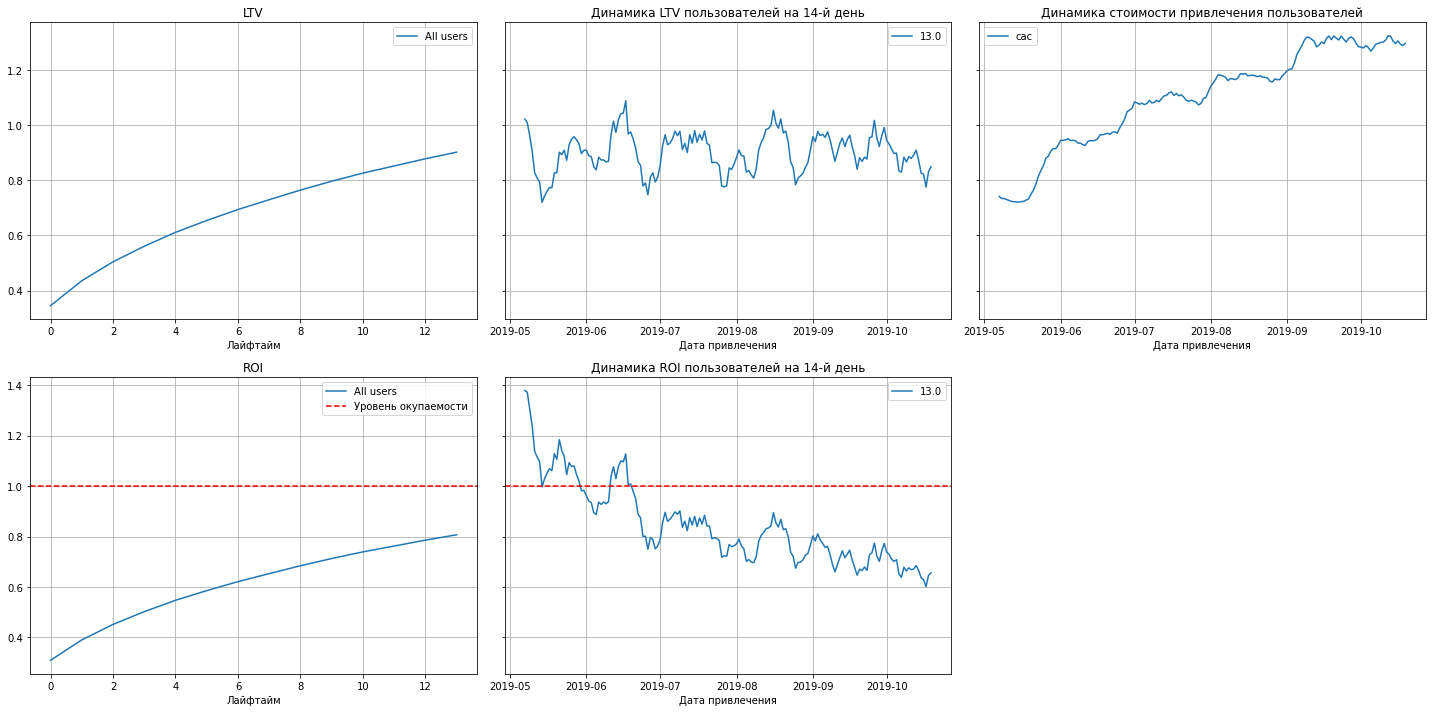

In [49]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:

- Реклама не окупается. ROI в концу двухнедельного интервала достигает только 80%, таким образом, в плюс выйти не удаётся.
- CAC имеет тенденцию к увеличению. Вероятно, дело в увеличении рекламного бюджета.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

### Анализ  окупаемости рекламы с разбивкой по устройствам

Чтобы разобраться в причинах, по которым несколько прошлых месяцев наш бизнес постоянно нес убытки, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.
Начнём с разбивки по устройствам: передадим параметру dimensions столбец device:

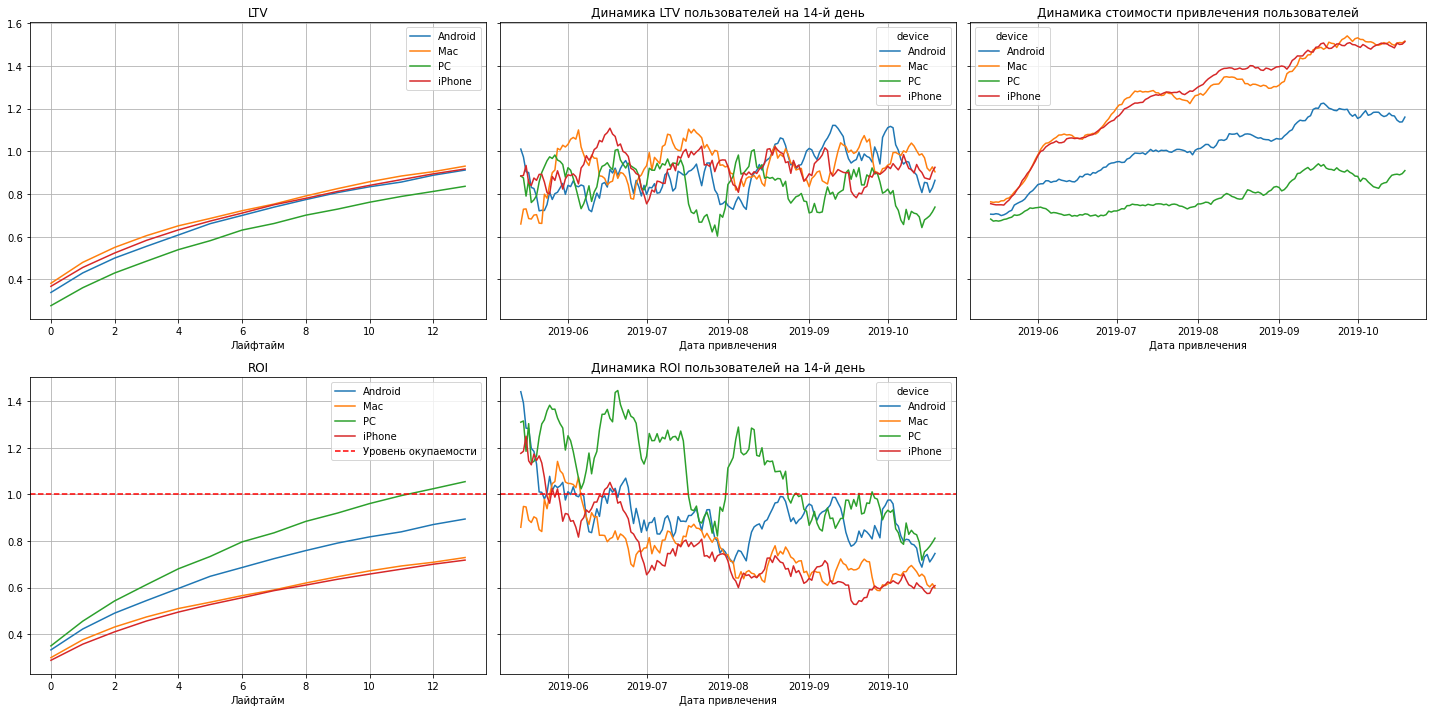

In [50]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Можно заметить, что в исследуемый период бюджет на привлечение пользователей был в наибольшей степени увеличен в направлении устройств iPhone и Mac. В то же время по графику ROI видно, что эта реклама не окупается - к концу горизонта анализа окупаемость инвестиций едва превосходит 70%. Узнаем, в чём причина: в низкой конверсии или низком удержании. Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion().

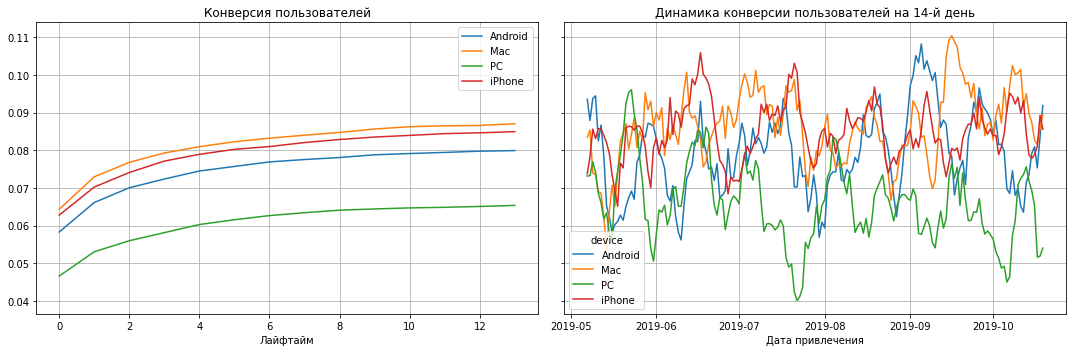

In [51]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    not_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи iPhone и Mac конвертируются хорошо, причём постоянно. Видимо, дело в удержании. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель:

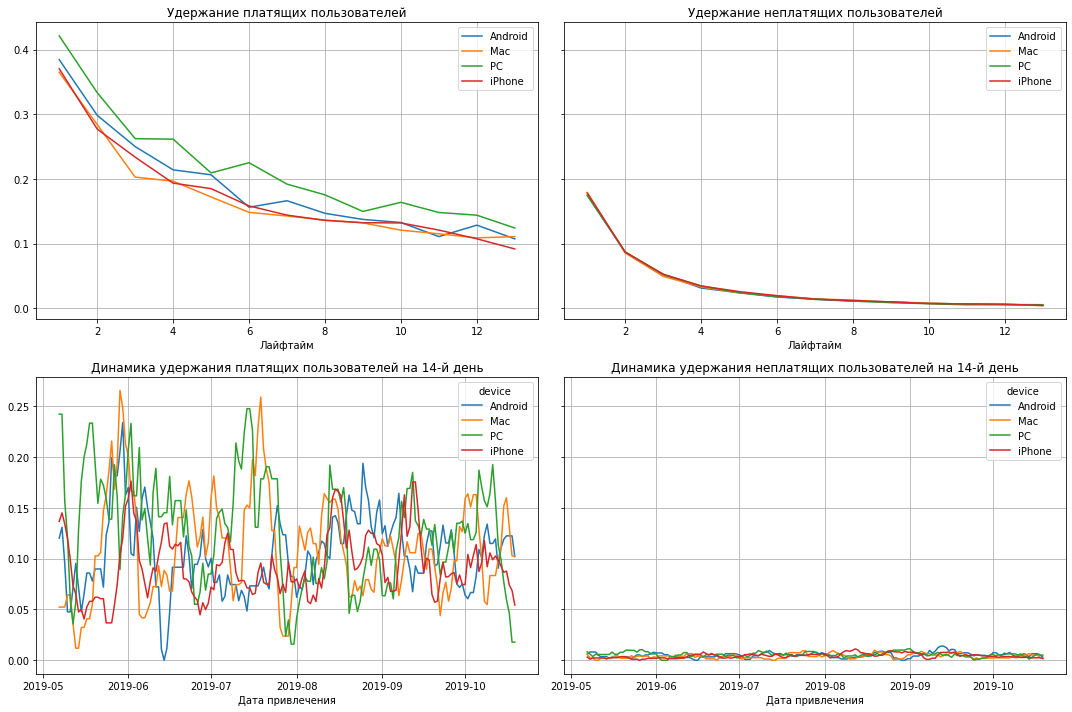

In [52]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    not_organic_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

По графикам можно заметить, что пользователи всех устройств стабильно плохо удерживаются. Таким образом, причина последних убытков спрятана не в типе устройства, с помощью которого пользователи заходят в приложение. Посмотрим, как ведут себя показатели в разбивке по странам.

### Анализируйте окупаемости рекламы с разбивкой по странам

Перейдем к странам:

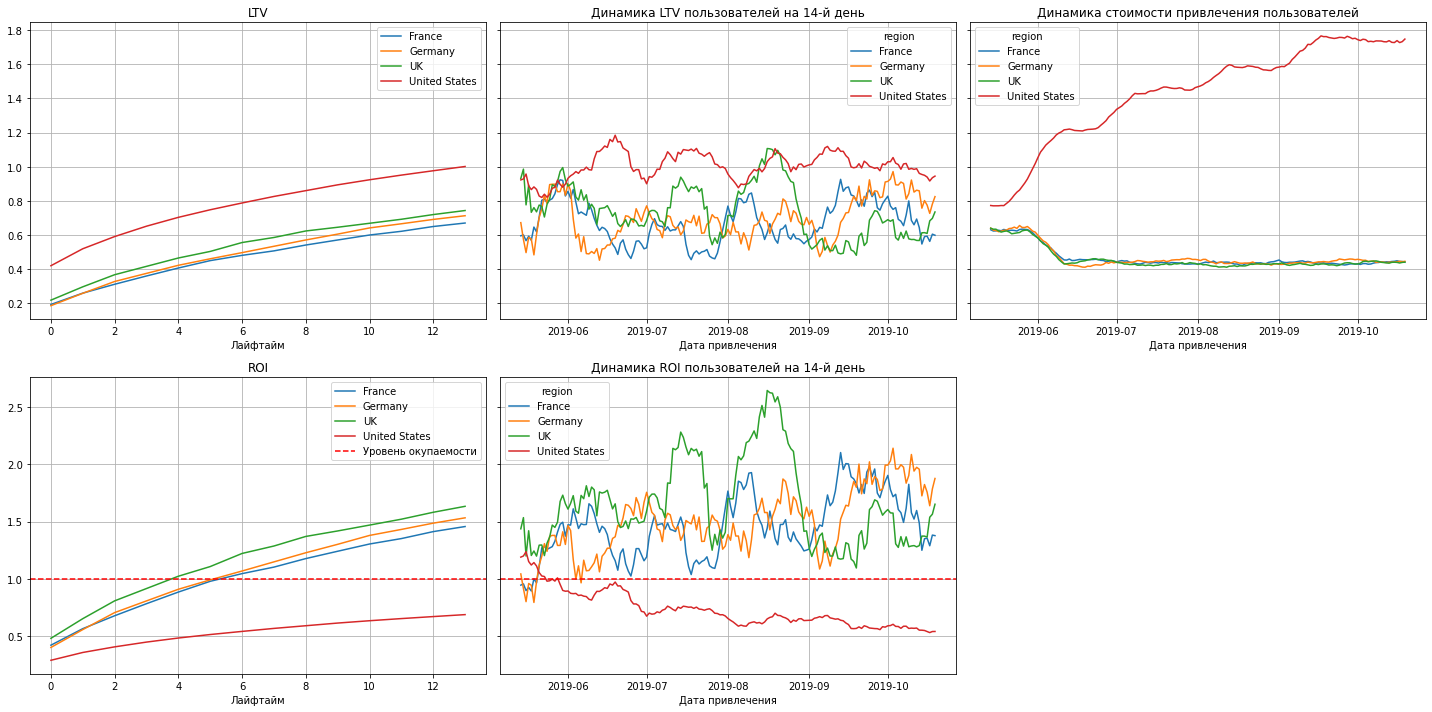

In [53]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Графики нам показывают явные проблемы показателей по США. Очевидно неоправданное увеличение бюджета на рекламу, она не окупается, а к концу исследуемого периода окупаемость инвестиций и вовсе сильно снизилась. Попробуем выяснить, причина в конверсии или удержании пользователей:

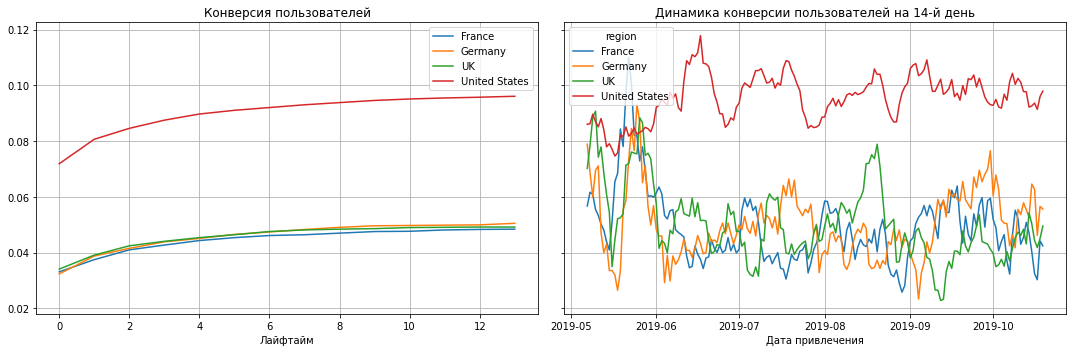

In [54]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    not_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи приложения из США конвертируются очень хорошо, причём постоянно. Видимо, дело в удержании. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель:

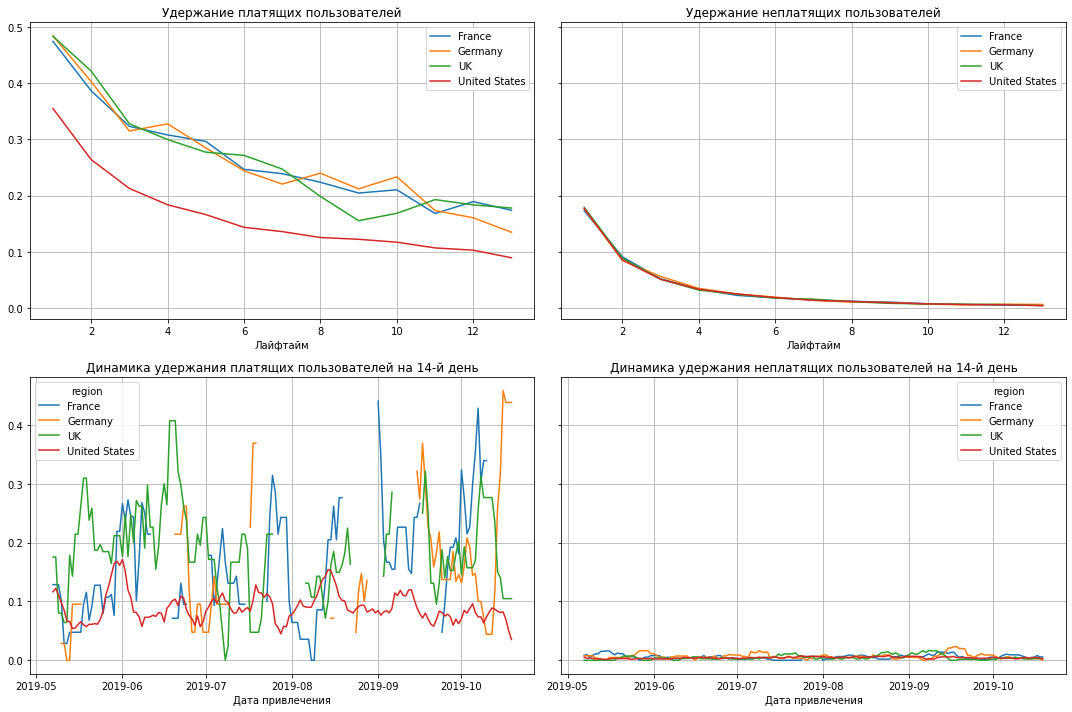

In [55]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    not_organic_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

По графикам можно заметить, что платящие пользователи из США удерживаются хуже, чем из других стран. Таким образом, имеет смысл пересмотреть географию рекламных вложений или же пересмотреть содержание этой рекламы, направить ресурсы именно на удержание пользователей. Например, разработать какую-нибудь систему бонусов и поощрений для постоянных клиентов.  
Интересно посмотреть уровень окупаемости отдельно по США с разбивкой по рекламным каналам:

Окупаемость с разбивкой по рекламным каналам по США:


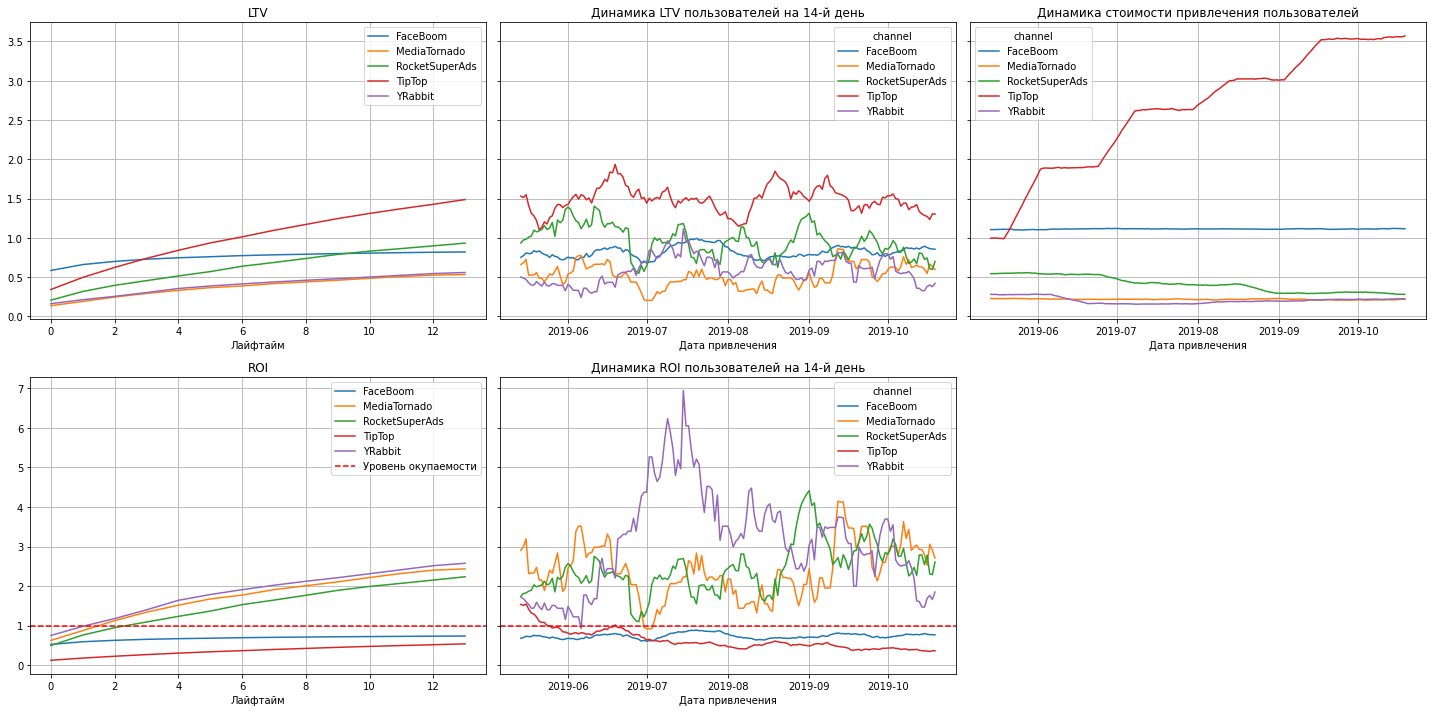

In [56]:
# смотрим окупаемость с разбивкой по рекламным каналам отдельно по США
print('Окупаемость с разбивкой по рекламным каналам по США:')
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic_profiles.query(
        'region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Из графиков видно, что наиболее затратные рекламные каналы в США не окупаются, а именно TipTop и FaceBoom. Имеет смысл рассмотреть снижение рекламного бюджета в этих направлениях.  
Попробуем определить перспективные рекламные направления и в европейских странах тоже:

Окупаемость с разбивкой по рекламным каналам по Европе:


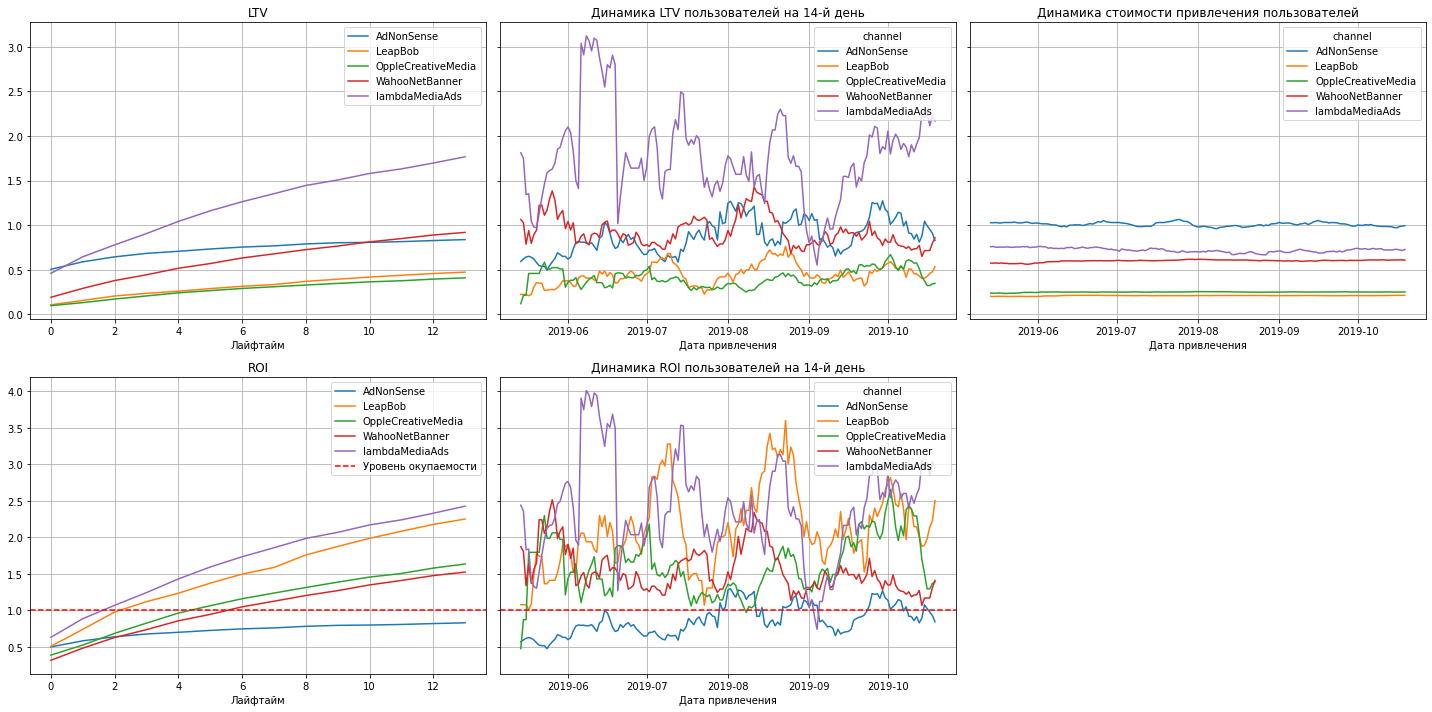

In [57]:
# смотрим окупаемость с разбивкой по рекламным каналам отдельно по Европе
print('Окупаемость с разбивкой по рекламным каналам по Европе:')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic_profiles.query(
        'region != "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

FaceBoom в Европе тоже не окупается. Имеет смысл обратить внимание на рекламу по LeapBob: при минимальной стоимости привлечения пользователей, возврат на инвестиции по этому каналу в числе лидирующих позиций.

 Посмотрим также, как ведут себя показатели всей выборки в разбивке по рекламным каналам.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

Теперь проверим источники привлечения (channel). Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале.

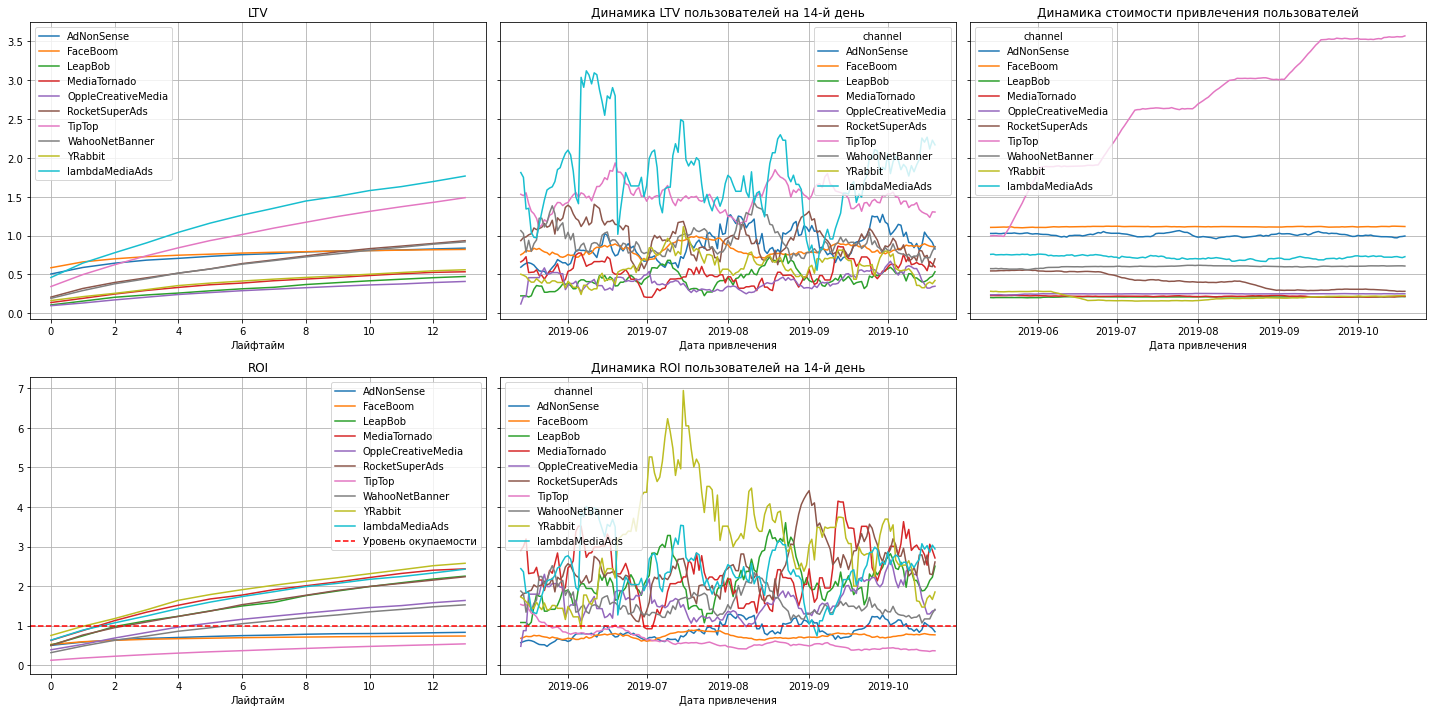

In [58]:
# смотрим окупаемость с разбивкой по источникам привлечения

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Можно заметить, реклама по каналам TipTop, AdNonSense и FaceBoom не окупается. Кроме того, стоимость привлечения пользователей по каналу TipTop в исследуемый период неоправданно выросла. Выясним, проблемы этих каналов связаны с конверсией или удержанием пользователей.

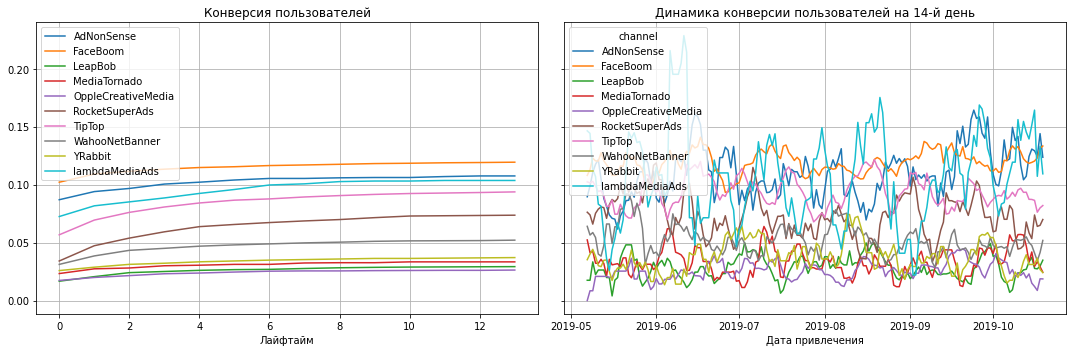

In [59]:
# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    not_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи приложения, привлечённые "проблемными" каналами (TipTop, AdNonSense и FaceBoom) конвертируются хорошо и постоянно. Посмотрим, как обстоят дела с удержанием. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель:

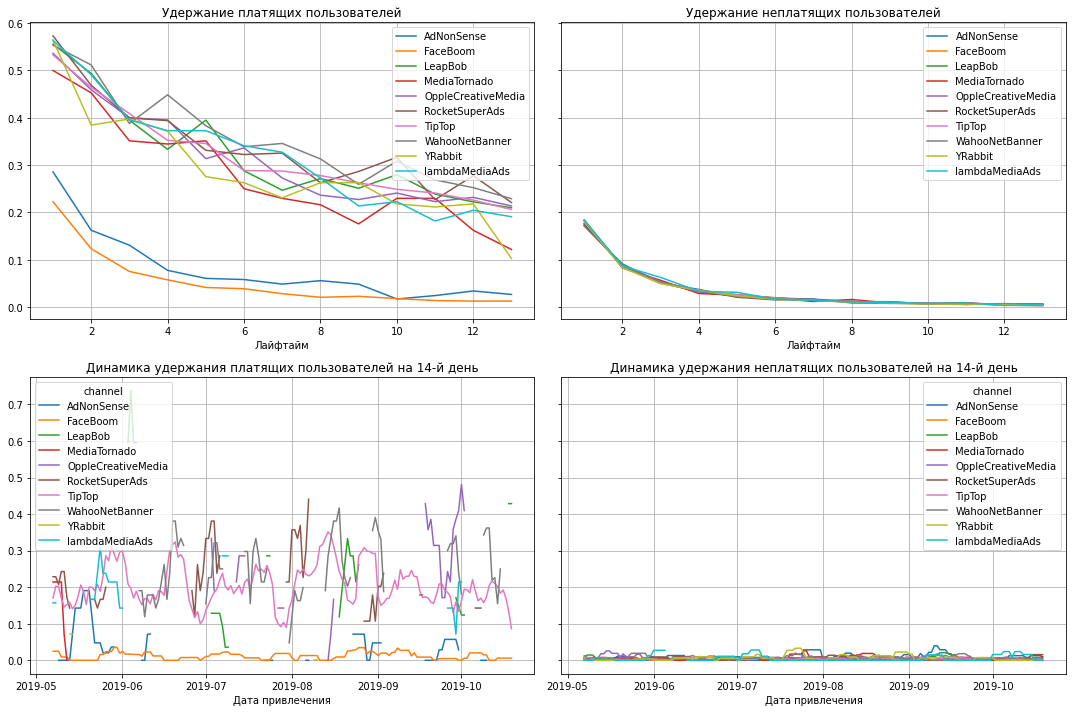

In [60]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    not_organic_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

По графикам можно заметить, что платящие пользователи, привлеченные каналами AdNonSense и FaceBoom удерживаются хуже примерно на 20%, чем по другим каналам. Показатели по каналу TipTop стабильны и находятся на уровне других рекламных каналов, поэтому нет смысла вкладывать в него больше денег.

Мы провели анализ окупаемости рекламы в разрезе стран, устройств пользователей и рекламных каналов. Общая ситуация такова: реклама не окупается, к концу двухнедельного цикла она достигает только 80% (то есть даже не покрывает вложения, не говоря уже о прибыли), уровень рекламных затрат имеет тенденцию к росту.  
Мы попытались выявить причины, по которым так происходит. При анализе рекламы в разрезе устройств пользователей мы выснили, что пользователи всех устройств стабильно плохо удерживаются. Таким образом, причина последних убытков спрятана не в типе устройства, с помощью которого пользователи заходят в приложение.  Далее мы изучили показатели в разрезе стран. Самая печальная картина наблюдается по США. Платящие пользователи из США удерживаются хуже, чем из других стран. Рассмотрели показатели окупаемости отдельно США и странам Европы, и выяснили, что рекламный бюджет в большей степени вкладывался в неперспективные рекламные каналы. Так, например, в США больше всего средств было вложено в TipTop, а воврат инвестиций по этому каналу самый низкий. В Европе же аналогичная картина сложилась с каналом TipTop.  
На последнем шаге исследования мы посмотрели показатели окупаемости по всей выборке в разрезе рекламных каналов, изучили конверсию и удержание. Платящие пользователи, привлеченные каналами AdNonSense и FaceBoom удерживаются хуже примерно на 20%, чем по другим каналам. Показатели по каналу TipTop стабильны и находятся на уровне других рекламных каналов, поэтому нет смысла вкладывать в него больше денег.

<a id='conclusion'></a>
## Общие выводы

Мы провели исследование показателей работы развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев наш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого.  Мы постарались разобраться в причинах этой ситуации.

Мы построили таблицу пользовательских профилей и изучили данные в ней.  
Определили период анализа: с 1 мая по 27 октября 2019 года.  
Выяснили, что развлекательное приложение Procrastinate Pro+ наиболее популярно среди пользователей Соединённых Штатов Америки (их доля около 70% от общего числа пользователей). Пользователи из Англии, Германии и Франции занимают 10-12%.  
Платящие пользователи из США составляют около 78%, а процент пользователей из трёх остальных исследуемых стран находится на уровне 7-8%.  
Если посмотреть на доли платящих пользователей в общем числе пользователей региона, то лидирующую позицию также занимают США (6.9%, что почти на три процентных пункта выше, чем в Германии, Англии и Франции).  
Большинство пользователей приложения используют устройства iPhone (36.3%). Около 20% пользователей посещают приложение с устройств PC и Mac, а 23.4% - с устройств Android.  
Платящие пользователи приложения Procrastinate Pro+ распределились в том же порядке: 38.1% - IPhone, 23.1% - Android, 21.5% - Mac и 17.3% - PC.  
Доля платящих пользователей по отношению к общему числу пользователей самая высокая среди владельцев Mac и iPhone (6.36% и 6.21% соответственно). Реже других платящие пользователи используют PC (5.05% от общего числа пользователей PC).  
В общем числе пользователей наибольший удельный вес занимают органические пользователи (37.6%), т. е. такие пользователи, которые приходят на ресурс после поиска через Google, Яндекс, Bing и т. п., не используя рекламные ссылки. Однако процент платящих пользователей среди них значительно ниже - только 13.1%. Интерес большого количества пользователей приложения был вызван рекламными каналами FaceBoom (19.4%) и TipTop (13.0%). Платящих пользователей среди них тоже много - 40.1% и 21.1% соответственно от общего количества платящих пользователей.  
Самый небольшой удельный вес платящих пользователей можно заметить среди органических пользователей (2.06% от всех органических пользователей). В то же время пользователи, привлеченные каналами FaceBoom и AdNonSense, чаще других используют платную версию приложения (12.2% и 11.34% соответственно).

Таким образом, мы получили средний портрет платящего пользователя: он из США, посещает приложение с устройста iPhone и был привлечён рекламным каналом FaceBoom. Что касается органических пользователей, на привлечение которых компания не потратила средств, то процент платящих среди них оставляет желать лучшего.

Далее мы изучили затраты на маркетинг. Для начала выяснили, что общая сумма затрат на рекламу в исследуемый период составила около 105.5 тыс. у.е., в том числе наибольшее количество денежных средств было вложено в рекламу на TipTop (около 54.8 тыс. у.е.) и на FaceBoom (около 32.4 тыс. у.е.).  
Рекламные затраты демострировали нам тенденцию к росту в период с мая по октябрь 2019 года, пик этих затрат пришёлся на конец сентября. Наращивание рекламных затрат происходило по двум рекламным каналам: TipTop и FaceBoom. По остальным каналам затраты на маркетинг были стабильны и значительно ниже.  
Далее мы изучили среднюю стоимость привлечения одного покупателя для всего проекта и в разрезе рекламных каналов. В среднем по проекту в исследуемый период стоимость привлечения одного покупателя составила 1.13 у.е.  
Наибольшие среднепользовательские рекламные затраты наблюдались по каналу TipTop (2.8 у.е.), что больше чем в два раза превышает среднепользовательские рекламные затраты для всего проекта. Далее по затратности следуют каналы FaceBoom (1.1 у.е. за пользователя) и AdNonSense (1.0 у.е. за пользователя).  
Для того, чтобы определить целесообразность данных затрат, нужно оценить окупаемость рекламы для привлечения пользователей, чем мы и занялись на следующем этапе исследования.

Установили момент и горизонт анализа данных, а также исключили органических пользоватей. Эти пользователи находят нас сами и, таким образом, наши рекламные вложения на них не влияют.  
Для начала оценили общую ситуацию — посмотрели на окупаемость рекламы. Построив графики LTV и ROI мы сделали следующие выводы:

- Реклама не окупается. ROI в концу двухнедельного интервала достигает только 80%, таким образом, в плюс выйти не удаётся.
- CAC имеет тенденцию к увеличению. Вероятно, дело в увеличении рекламного бюджета.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

Мы прошлись по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения, чтобы разобраться в причинах, по которым несколько прошлых месяцев наш бизнес постоянно нес убытки. Начали с разбивки по устройствам. В исследуемый период бюджет на привлечение пользователей был в наибольшей степени увеличен в направлении устройств iPhone и Mac. В то же время по графику ROI видно, что эта реклама не окупается - к концу горизонта анализа окупаемость инвестиций едва превосходит 70%. Мы построили графики конверсии и удержания в разрезе устройств и выснили, что пользователи всех устройств стабильно плохо удерживаются. Таким образом, причина последних убытков спрятана не в типе устройства, с помощью которого пользователи заходят в приложение. Изучили, как ведут себя показатели в разбивке по странам.  
Мы установили явные проблемы показателей по США. Очевидно неоправданное увеличение бюджета на рекламу, она не окупается, а к концу исследуемого периода окупаемость инвестиций и вовсе сильно снизилась. Платящие пользователи из США удерживаются хуже, чем из других стран. Таким образом, имеет смысл пересмотреть географию рекламных вложений или же пересмотреть содержание этой рекламы, направить ресурсы именно на удержание пользователей. Например, разработать какую-нибудь систему бонусов и поощрений для постоянных клиентов.  
На заключительном этапе исследования мы оценили окупаемость рекламы в разреле различных рекламных каналов. Реклама по каналам TipTop, AdNonSense и FaceBoom не окупается. Кроме того, стоимость привлечения пользователей по каналу TipTop в исследуемый период неоправданно выросла. Платящие пользователи, привлеченные каналами AdNonSense и FaceBoom удерживаются хуже примерно на 20%, чем по другим каналам. Показатели по каналу TipTop стабильны и находятся на уровне других рекламных каналов, поэтому нет смысла вкладывать в него больше денег.

Приняв во внимание всё выше изложенное, можно порекомендовать пересмотреть рекламные кампании фирмы. Например, на рынке США основным курсом нужно взять - удержание пользователей. Имеет смысл пересмотреть рекламные каналы (затраты на FaceBoom и TipTop здесь неоправданно высоки). Сделать упор на те каналы, где характеристики конверсии и удержания получше. Например, YRabbit (в США) или lambdaMediaAds (в Европе). Что касается Европы, то FaceBoom там тоже не окупается. Имеет смысл обратить внимание на рекламу по LeapBob: при минимальной стоимости привлечения пользователей, возврат на инвестиции по этому каналу в числе лидирующих позиций. Таким образом, снизив рекламный бюджет по неперспективным направлениям, можно добиться оптимизации затрат, и, соответственно, роста прибыли.

Кроме того, имеет смысл присмотреться к органическим пользователям. Они очень ценны тем, что сами заинтересовались нашим продуктом, а наша задача состоит в том, чтобы  удержать их интерес. Дополнительно можно узучить, на каком этапе интерес пользоватей теряется, чтобы понять причины и попытаться их устранить. Например, упростить процедуру регистрации, если она "отпугивает" пользователей или что-то подобное.